In [9]:
import dice_ml
from dice_ml import Dice
from dice_ml.utils.exception import UserConfigValidationException

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, fetch_california_housing

from src.transition_system import transition_system, indexs_for_window, list_to_str
from src.function_store import StoreTestRun, extract_algo_name, generate_cfe, get_case_id, prepare_df_for_ml, \
    activity_n_resources, get_test_cases, get_prefix_of_activities, validate_transition

import pandas as pd
import os
import pickle
import random
import subprocess
from IPython.display import display
from math import ceil
from time import time
import warnings
from wrapt_timeout_decorator import timeout
import matplotlib.pyplot as plt

# from multiprocessing import Process
# from timeout_decorator import timeout, TimeoutError
# import signal
from typing import Tuple, Any
from collections import Counter
import utils
from time import sleep
pd.options.display.max_columns = 50
pd.set_option('display.max_rows', 500)
if "src" in os.getcwd():
    os.chdir("../")

SECONDS_TO_HOURS = 60 * 60
SECONDS_TO_DAYS = 60 * 60 * 24

# Suppress all warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imp
For activity occurrence we'll use 10 buckets with 30 elements each. Due to few cases with activity_to_avoid we want to optimally use the traces

In [10]:
# === Helper functions =================================
def lowest_lead_time(df, case_id):
    return df.loc[df[case_id_name] == case_id, "lead_time"].min()

def cases_with_activity_to_avoid(df, activity_column_name, activity_to_avoid):
    """
    Returns:
        case_ids_with_activity_to_avoid, case_ids_without_activity_to_avoid
    """
    # === How much traces have `activity_to_avoid`
    case_ids_with_activity_to_avoid = []
    case_ids_without_activity_to_avoid = []
    gdf = df.groupby(case_id_name)
    for case_id, group in gdf:
        if activity_to_avoid in group[activity_column_name].to_list():
            case_ids_with_activity_to_avoid.append(case_id)
        else:
            case_ids_without_activity_to_avoid.append(case_id)
    # print(f"Cases with activity_to_avoid: {len(case_ids_with_activity_to_avoid):,}")
    # print(f"Cases without activity_to_avoid: {len(case_ids_without_activity_to_avoid):,}")
    return case_ids_with_activity_to_avoid, case_ids_without_activity_to_avoid

### Uncomment the dataset you want to use

In [11]:
dataset = "VINST cases incidents.csv"               # VINST case incident, for Total Time KPI optimization
# dataset = "bank_account_closure.csv"                # bank_account_closure, for Activity Occurrence KPI optimization
BUCKET_SIZE = 50
NUMBER_OF_BUCKETS = 10

data_dir = "./preprocessed_datasets/"
if dataset == "VINST cases incidents.csv":
    KPI = "total_time"
    case_id_name = 'SR_Number'  # The case identifier column name.
    start_date_name = 'Change_Date+Time'  # Maybe change to start_et (start even time)
    activity_column_name = "ACTIVITY"
    resource_column_name = "Involved_ST"
    role_column_name = "Involved_Org_line_3"
    end_date_name = None
    train_dataset_file = "vinst_train.csv"
    # test_dataset_file = "vinst_test.csv"
    # test_pickle_dataset_file = "vinst_test.pkl"
    test_dataset_file = "vinst_test-500.csv"
    test_pickle_dataset_file = "vinst_test-500.pkl"
    df = pd.read_csv(f"./data/{dataset}")  # Use full dataset for transition systens
    df_train = pd.read_csv(os.path.join(data_dir, train_dataset_file))
    df_test = pd.read_csv(os.path.join(data_dir, test_dataset_file))
else:  # dataset == "bank_account_closure.csv":
    KPI = "activity_occurrence"
    case_id_name = "REQUEST_ID"
    start_date_name = "START_DATE"
    activity_column_name = "ACTIVITY"
    resource_column_name = "CE_UO"
    role_column_name = "ROLE"
    end_date_name = "END_DATE"
    activity_to_avoid = "Back-Office Adjustment Requested"
    train_size = 0.8                  # Where the time split happens on the dataset
    train_dataset_file = "bank_acc_train.csv"
    # test_dataset_file = "bank_acc_test.csv"
    # test_pickle_dataset_file = "bank_acc_test.pkl"
    test_dataset_file = "bank_acc_test-500.csv"
    test_pickle_dataset_file = "bank_acc_test-500.pkl"
    df = pd.read_csv(f"./data/{dataset}")  # concern: what is date col position is different?
    df[start_date_name] = pd.to_numeric( df[start_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds
    df[end_date_name] = pd.to_numeric( df[end_date_name] ) // 1_000  # Convert Epochs from milliseconds to seconds
    df_train = pd.read_csv(os.path.join(data_dir, train_dataset_file))
    df_test = pd.read_csv(os.path.join(data_dir, test_dataset_file))

In [12]:
test_cases = get_test_cases(None, None, load_dataset=True, path_and_filename=os.path.join(data_dir, test_pickle_dataset_file))
print(f"Number of cases in the test set: {len(test_cases):,}")

Number of cases in the test set: 500


## Create Test Bucket
Instead of nesting the data structure to create 10 buckets we assume a buket is set of 50 cases. So first 50 cases, indexes 0:49, are the 1st bucket, next 50 cases,
indexes 50:99, are the 2nd bucket and so on.

### Below we Create and Save the final test set

In [13]:
# # test_bucket_set = random.sample(test_cases, 500)
# if KPI == "activity_occurrence":
#     # === From test_cases first filter out the cases with `activity_to_avoid`.
#     test_case_ids = []
#     for test_case in test_cases:
#         test_case_ids.append( get_case_id(test_case, case_id_name) )
#
#     df_temp = df[ df[case_id_name].isin(test_case_ids) ].copy()
#     df_temp = df_temp.reset_index(drop=True)
#     case_ids_with_activity_to_avoid_test, _ = cases_with_activity_to_avoid(df_test, activity_column_name, activity_to_avoid)
#     print(f"# Cases with `activity_to_avoid` in entire Test Set: {len(case_ids_with_activity_to_avoid_test)}")
#
#     case_ids_for_result = random.sample(case_ids_with_activity_to_avoid_test, NUMBER_OF_BUCKETS * BUCKET_SIZE)  # 500
#
#     # === Use the `case_ids_for_result` and get these traces from `test_cases`
#     new_test_cases = []
#     for test_case in test_cases:
#         if get_case_id(test_case, case_id_name) in case_ids_for_result:
#             new_test_cases.append( test_case )
#
#     # # === Do sanity check and make sure test_case_ids_for_result has cases which have the activity to avoid
#     df_test = df_test[ df_test[case_id_name].isin(case_ids_for_result) ].copy()
#     df_test = df_test.reset_index(drop=True)
#     case_ids_with_activity_to_avoid_test, _ = cases_with_activity_to_avoid(df_test, activity_column_name, activity_to_avoid)
#     print(f"# Cases with `activity_to_avoid` in entire Test Set: {len(case_ids_with_activity_to_avoid_test)}")
#
#     # === Save this dataset for generating results (comment because we don't want to overwrite)
#     # df_test.to_csv( os.path.join(data_dir, "bank_acc_test-500.csv"), index=False)
#     # with open(os.path.join(data_dir, test_pickle_dataset_file), 'wb') as file:
#     #     pickle.dump(new_test_cases, file)
#
# else:  # kpi total_time
#     new_test_cases = random.sample(test_cases, NUMBER_OF_BUCKETS * BUCKET_SIZE)  # 500
#
#     # === create df_test
#     case_ids_of_new_test_cases = []
#     for test_case in new_test_cases:
#         case_ids_of_new_test_cases.append( get_case_id(test_case, case_id_name) )
#
#     df_test = df_test[ df_test[case_id_name].isin(case_ids_of_new_test_cases) ].copy()
#     df_test = df_test.reset_index(drop=True)
#
#     # === Save this dataset for generating results (comment because we don't want to overwrite)
#     # df_test.to_csv( os.path.join(data_dir, "vinst_test-500.csv"), index=False)
#     # with open(os.path.join(data_dir, test_pickle_dataset_file), 'wb') as file:
#     #     pickle.dump(new_test_cases, file)


In [6]:
if KPI == "total_time":
    pickle_file = "random-t33.pkl"
else:
    pickle_file = "random-a23.pkl"

if not os.path.exists( f"./experiment_results/{pickle_file}"):
    result = subprocess.run(['scp', f'labnum08:git_repos/explainable-prescriptive-analytics/experiment_results/{pickle_file}', 'experiment_results/'], capture_output=True, text=True)
    # return code of 0 means the command executed successfully
    if result.returncode != 0:
        print("There is an Error in the command")
    else:
        print("successful")
else:
    print(f"File already exists")

RESULTS_FILE_PATH_N_NAME = f"experiment_results/{pickle_file.split('.')[0]}.csv"
# The file name passed to the function is .csv, but it doesn't read that, it reads the .pkl file'
state_obj = StoreTestRun(save_load_path=RESULTS_FILE_PATH_N_NAME)
save_load_path = state_obj.get_save_load_path()

state_obj.load_state()

File already exists


In [8]:
# state_obj.run_state
RESULTS_FILE_PATH_N_NAME

'experiment_results/random-t33.csv'

## Extract information from state_obj
Create `results_bucket_set` from the results in the `state_obj.run_state`

In [36]:
# Suffle cases
# test_cases = random.sample(test_cases, NUMBER_OF_BUCKETS * BUCKET_SIZE)  # 500

In [37]:
# with open(os.path.join(data_dir, test_pickle_dataset_file), 'wb') as file:
#     pickle.dump(test_cases, file)

In [38]:
results_bucket_set = []  # add results_bucket in it after it has 50 elements
results_bucket = []

### Check for each bucket how many traces in each bucket have a CFE
bucket_set_stats = []
bucket_stats = 0

for i, test_bucket in enumerate(test_cases):

    case_id_from_bucket = get_case_id(test_bucket, case_id_name)
    # If a cf was found for this case id the assignment below will replace "cfe_not_found" with cfe_df
    bucket_element = [case_id_from_bucket, "cfe_not_found"]
    # print(f"case id: {case_id_from_bucket}")
    for case_id, value in state_obj.run_state["cfe_after_validation"]:
        if case_id == case_id_from_bucket:
            # check if CFE exists
            if isinstance(value, pd.DataFrame):
                # change the value from "cfe_not_found" to the dataframe containing CFEs
                bucket_element[1] = value
                bucket_stats += 1

    results_bucket.append(bucket_element)

    # After BUCKET_SIZE elements add the results_bucket to the results_bucket_set Cuz indexing starts from 0 so.
    if (i+1) % BUCKET_SIZE == 0:
        results_bucket_set.append(results_bucket)
        results_bucket = []
        bucket_set_stats.append(bucket_stats)
        bucket_stats = 0

len(results_bucket_set)
bucket_set_stats[0]

22

In [45]:
for elem in results_bucket_set:
    assert len(elem) == BUCKET_SIZE
# For Total Time KPI elements

if KPI == "total_time":
    ###################################
    # Per Bucket Time KPI aggregation
    ###################################
    total_time_predicted = []
    total_time_actual = []
    cfe_found_count = []
    for results_bucket in results_bucket_set:
        counter = 0
        total_time = 0  # unit is seconds
        for case_id, value in results_bucket:
            if isinstance(value, pd.DataFrame):
                # Get the lowest value of lead_time from all CFEs
                total_time += value["lead_time"].min()
                counter += 1
            else:
                total_time += lowest_lead_time(df_test, case_id)

        total_time_predicted.append(total_time // SECONDS_TO_DAYS)
        cfe_found_count.append(counter)

        total_time = 0  # unit is seconds
        for case_id, value in results_bucket:
            total_time += lowest_lead_time(df_test, case_id)
        total_time_actual.append(total_time // SECONDS_TO_DAYS)

        # print( f"for bucket: {1} expected time: {total_time_predicted // SECONDS_TO_DAYS}, Actual time in logs: {total_time_actual // SECONDS_TO_DAYS }")
    df_time = pd.DataFrame({"total_time_predicted": total_time_predicted, "total_time_actual": total_time_actual,
                            "cfe_found": cfe_found_count, "num_of_cases": [BUCKET_SIZE] * NUMBER_OF_BUCKETS})

In [43]:
results_bucket_set[0]

50

In [26]:

if KPI == "activity_occurrence":
    ###################################
    # Per Bucket Count good suggestions to avoid the Activity (counterfactual examples)
    ###################################
    cfes_found = []
    cfes_not_found = []
    for i, bucket in enumerate(bucket_set_stats):
        cfes_found.append(bucket)
        cfes_not_found.append( BUCKET_SIZE - bucket )
        # print(f"Number of CFE found in bucket {i+1}: {bucket} / {BUCKET_SIZE}")

    df = pd.DataFrame( {"cfes_found": cfes_found, "total_cases": [BUCKET_SIZE] * NUMBER_OF_BUCKETS, "cfes_not_found": cfes_not_found } )

## Plot Results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


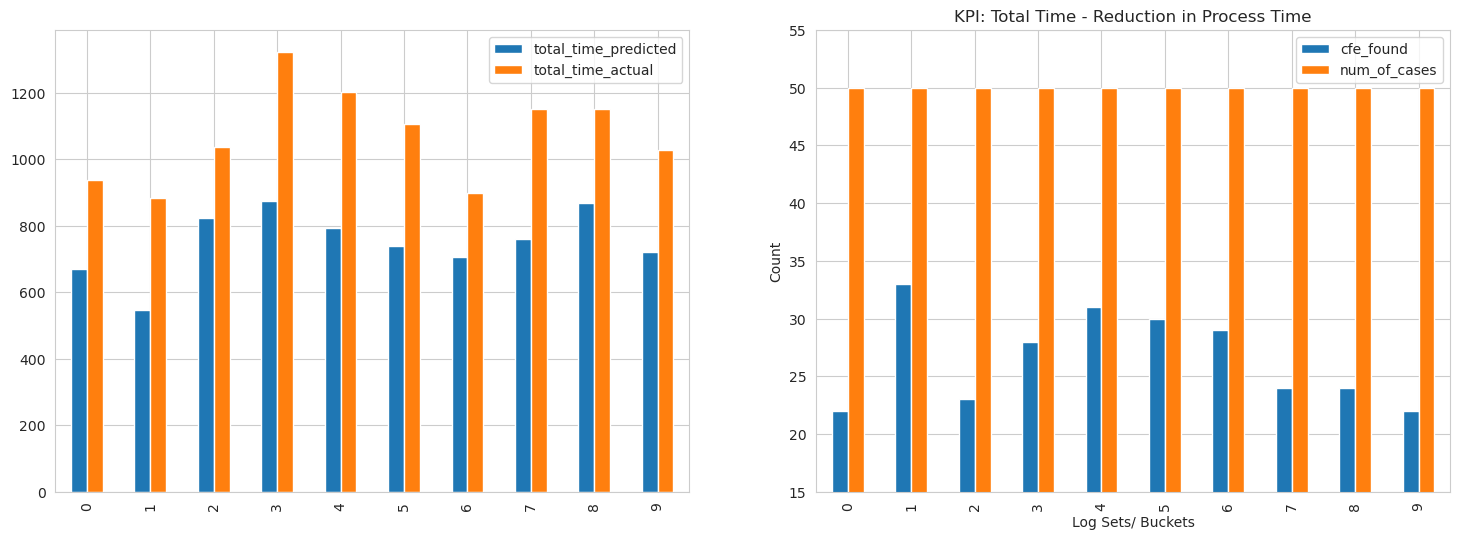

In [53]:
if KPI == "total_time":
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    df_time[["total_time_predicted", "total_time_actual"]].plot(kind='bar', ax=axes[0])

    plt.title('KPI: Total Time - Reduction in Process Time')
    plt.xlabel('Log Sets/ Buckets')
    plt.ylabel('Days'); plt.ylim(500, 1_350)
    plt.legend(loc='upper right')

    df_time[["cfe_found", "num_of_cases"]].plot(kind='bar', ax=axes[1])
    plt.xlabel('Log Sets/ Buckets')
    plt.ylabel('Count'); plt.ylim(15, 55)
    plt.legend(loc='upper right')


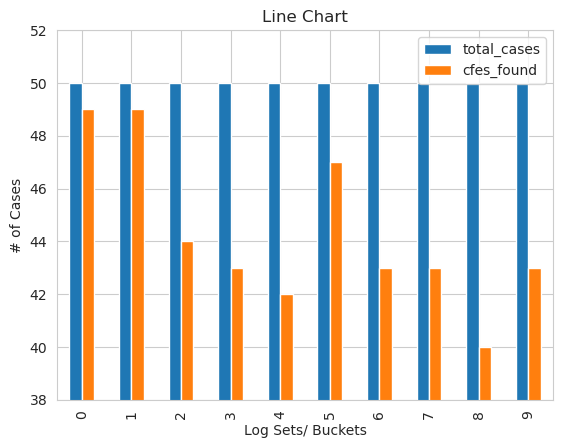

In [29]:
if KPI == "activity_occurrence":
    df[["total_cases", "cfes_found"]].plot(kind='bar')

    plt.title('Line Chart')
    plt.xlabel('Log Sets/ Buckets')
    plt.ylabel('# of Cases'); plt.ylim(38, 52)
    plt.legend(loc='upper right')

## Generate a CSV with all the CFEs for the test_cases

In [51]:
if KPI == "total_time":
    df_test_cases_cfes = pd.DataFrame(columns=df_test.columns)
    for results_bucket in results_bucket_set:
        # total_time = 0  # unit is seconds
        for case_id, value in results_bucket:
            if isinstance(value, pd.DataFrame):
                # Get the lowest value of lead_time from all CFEs
                cfe = value.loc[ [value["lead_time"].idxmin()] ]
                cfe[case_id_name] = case_id
                df_test_cases_cfes = pd.concat([df_test_cases_cfes, cfe], axis="rows")

    # df_test_cases_cfes.to_csv("vinst_total_time_recommendations.csv", index=False)
else:
    df_test_cases_cfes = pd.DataFrame(columns=df_test.columns)
    for results_bucket in results_bucket_set:
        # total_time = 0  # unit is seconds
        for case_id, value in results_bucket:
            if isinstance(value, pd.DataFrame):
                # Get the first CFE
                cfe = value.loc[ [0] ]
                cfe[case_id_name] = case_id
                df_test_cases_cfes = pd.concat([df_test_cases_cfes, cfe], axis="rows")
    # df_test_cases_cfes.to_csv("bank_acc_activity_occurrence_recommendations.csv", index=False)

In [31]:
df_test_cases_cfes

,REQUEST_ID,START_DATE,CLOSURE_TYPE,CLOSURE_REASON,ACTIVITY,END_DATE,CE_UO,ROLE,time_from_first,time_from_previous_et,time_from_midnight,weekday,activity_duration,time_remaining,# ACTIVITY=Service closure Request with network responsibility,# ACTIVITY=Service closure Request with BO responsibility,# ACTIVITY=Pending Request for Reservation Closure,# ACTIVITY=Pending Liquidation Request,# ACTIVITY=Request completed with account closure,# ACTIVITY=Request created,# ACTIVITY=Authorization Requested,# ACTIVITY=Evaluating Request (NO registered letter),# ACTIVITY=Network Adjustment Requested,# ACTIVITY=Pending Request for acquittance of heirs,# ACTIVITY=Request deleted,# ACTIVITY=Back-Office Adjustment Requested,# ACTIVITY=Evaluating Request (WITH registered letter),# ACTIVITY=Request completed with customer recovery,# ACTIVITY=Pending Request for Network Information,Back-Office Adjustment Requested
0,20191000037,NaN,Bank Recess,1 - Client lost,Network Adjustment Requested,NaN,00383,BACK-OFFICE,22860,22066,53508,Tuesday,196,NaN,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0
0,20191000083,NaN,Bank Recess,1 - Client lost,Network Adjustment Requested,NaN,00136,BACK-OFFICE,702700,702390,45270,Thursday,97829,NaN,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
0,20191000166,NaN,Client Recess,1 - Client lost,Back-Office Adjustment Requested,NaN,SDC,BACK-OFFICE,1185289,150650,11862,Wednesday,137671,NaN,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0
0,20191000230,NaN,Client Recess,1 - Client lost,Network Adjustment Requested,NaN,00756,BACK-OFFICE,613178,585311,46140,Wednesday,141,NaN,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
0,20191000272,NaN,Client Recess,1 - Client lost,Pending Request for Reservation Closure,NaN,BOC,BACK-OFFICE,1182559,149997,11927,Wednesday,137622,NaN,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0
0,20191000322,NaN,Client Recess,1 - Client lost,Pending Request for Reservation Closure,NaN,SDC,BACK-OFFICE,694319,692259,43640,Thursday,2,NaN,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
0,20191000324,NaN,Client Recess,1 - Client lost,Service closure Request with BO responsibility,NaN,missing,BACK-OFFICE,2383,23,42877,Wednesday,514089,NaN,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
0,20191000404,NaN,Client Recess,7 - Keep other relationships. Same dip,Pending Liquidation Request,NaN,BOCCRF,BACK-OFFICE,1038201,68,44346,Monday,140452,NaN,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0
0,20191000540,NaN,Bank Recess,1 - Client lost,Pending Liquidation Request,NaN,SDC,BACK-OFFICE,688274,96,44365,Thursday,140469,NaN,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0
0,20191000753,NaN,Bank Recess,1 - Client lost,Network Adjustment Requested,NaN,00708,BACK-OFFICE,514339,514065,54721,Tuesday,189,NaN,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0


# Deprecated Code

In [7]:
# a = [6, 5, 4, 1, 2, 3]
# Ascending
# a = [6, 5, 4, 3, 2, 1]
# Bubble Sort
a = [1, 2, 3, 4, 5, 6]
print(a)
def bubble_sort(a: list) -> list:
    for i in range(len(a)):
        for j in range( 0, len(a) - i - 1):
            if a[j] > a[j + 1]:
                a[j], a[j + 1] = a[j + 1], a[j]
    return a

[1, 2, 3, 4, 5, 6]


In [131]:
num = 14
steps = 0
def calc_steps( num ):
    if num <= 0:
        return 0
    if num % 2 == 0:  # if even
        steps = calc_steps( num // 2 )
    else:  # if odd
        steps = calc_steps( num - 1 )
    return steps + 1

a = calc_steps( num )
print("a is:", a)

a is: 6


In [149]:
i = 1


3